# Wines Points prediction 

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')

Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

## Loading the data

In [2]:
import pandas as pd
import cufflinks as cf; cf.go_offline()

In [3]:
wine_reviews = pd.read_csv("data/winemag-data-130k-v2.csv")
wine_reviews.shape

(129971, 14)

In [4]:
wine_reviews.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [5]:
wine_reviews.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
29800,29800,US,This beautiful Cabernet has all the hallmarks ...,Reserve,94,135.0,California,Napa Valley,Napa,NaN,NaN,ZD 2009 Reserve Cabernet Sauvignon (Napa Valley),Cabernet Sauvignon,ZD
14358,14358,Italy,The wine's beauty and intensity are impossible...,Altero,94,115.0,Tuscany,Brunello di Montalcino,NaN,NaN,NaN,Poggio Antico 2004 Altero (Brunello di Montal...,Sangiovese Grosso,Poggio Antico
21873,21873,US,Three things characterize this wine: exception...,NaN,92,80.0,California,Napa Valley,Napa,NaN,NaN,Valance 2007 Cabernet Sauvignon (Napa Valley),Cabernet Sauvignon,Valance
69989,69989,Italy,"This sparkler, made from from 100% Chardonnay,...",Satèn Millesimato,87,41.0,Lombardy,Franciacorta,NaN,Kerin O’Keefe,@kerinokeefe,Le Marchesine 2009 Satèn Millesimato Chardonna...,Chardonnay,Le Marchesine
41451,41451,Italy,"Toast, oak, menthol and coconut aromas carry o...",Riserva,86,75.0,Piedmont,Barolo,NaN,Kerin O’Keefe,@kerinokeefe,Virna Borgogno 2010 Riserva (Barolo),Nebbiolo,Virna Borgogno


In [6]:
wine_reviews = wine_reviews.drop(columns=['Unnamed: 0'])

In [7]:
wine_reviews = wine_reviews.drop_duplicates()
wine_reviews.shape

(119988, 13)

## Points prediction

Points is descrete value target. There for we are talking about a prediction (Regression) problem (in contrary to classification problem). Prediction solutions can be measured in few metrics:

* MSE - [Mean score error](https://en.wikipedia.org/wiki/Mean_squared_error)
* R2 - [R Square](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* MAE - [Mean absolut error](https://en.wikipedia.org/wiki/Mean_absolute_error)

Read more [here](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)

### Train and test set split

To properly report results, let's split to train and test datasets:

In [8]:
train_data = wine_reviews.sample(frac = 0.8)
test_data = wine_reviews[~wine_reviews.index.isin(train_data.index)]
assert(len(train_data) + len(test_data) == len(wine_reviews))

In [9]:
len(test_data), len(train_data)

(23998, 95990)

In [10]:
all_features = train_data.columns.tolist()#.remove("description")#.head()
all_features.remove("points")
print(all_features)

['country', 'description', 'designation', 'price', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery']


### Baselines

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [12]:
def calc_prediction_quality(df, pred_score_col, true_score_col):
    return pd.Series({'MSE': mean_squared_error(df[true_score_col], df[pred_score_col]),
                      'MAE': mean_absolute_error(df[true_score_col], df[pred_score_col]),
                      'R2': r2_score(df[true_score_col], df[pred_score_col])})

#### Baseline 1

The most basic baseline is simply the average points. The implementaion is as simple as:

In [13]:
test_data['basiline_1_predicted_points'] = train_data.points.mean()
b1_stats = calc_prediction_quality(test_data, 'basiline_1_predicted_points', 'points')
b1_stats

MSE    9.531632
MAE    2.534622
R2    -0.000007
dtype: float64

#### Basline 2

We can probably improve by predicting the average score based on the origin country:

In [14]:
avg_points_by_country = train_data.groupby('country').points.mean()
avg_points_by_country.head()

country
Argentina                 86.664051
Armenia                   87.500000
Australia                 88.587760
Austria                   90.138238
Bosnia and Herzegovina    86.500000
Name: points, dtype: float64

In [15]:
test_data['basiline_2_predicted_points'] = test_data.country.map(avg_points_by_country).fillna(train_data.points.mean())
b2_stats = calc_prediction_quality(test_data, 'basiline_2_predicted_points', 'points')
b2_stats

MSE    9.062183
MAE    2.466627
R2     0.049245
dtype: float64

### Baseline 3

Adding more breakdowns will increase our granularity but can result in overfitting. Yet:

In [16]:
avg_points_by_country_and_region = train_data.groupby(['country','province']).points.mean().rename('basiline_3_predicted_points')
avg_points_by_country_and_region.head()

country    province        
Argentina  Mendoza Province    86.774220
           Other               86.000000
Armenia    Armenia             87.500000
Australia  Australia Other     85.541436
           New South Wales     87.892308
Name: basiline_3_predicted_points, dtype: float64

In [17]:
test_data_with_baseline_3 = test_data.merge(avg_points_by_country_and_region, on = ['country','province'], how='left')
test_data_with_baseline_3.basiline_3_predicted_points = test_data_with_baseline_3.basiline_3_predicted_points.fillna(test_data_with_baseline_3.basiline_2_predicted_points).fillna(test_data.basiline_1_predicted_points)
test_data_with_baseline_3.shape, test_data.shape

((23998, 16), (23998, 15))

In [18]:
b3_stats = calc_prediction_quality(test_data_with_baseline_3, 'basiline_3_predicted_points', 'points')
b3_stats

MSE    8.482525
MAE    2.368011
R2     0.110060
dtype: float64

### Baselines summary

In [19]:
baseline_summary = pd.DataFrame([b1_stats, b2_stats, b3_stats], index=['baseline_1', 'baseline_2','baseline_3'])
baseline_summary

,MSE,MAE,R2
baseline_1,9.531632,2.534622,-0.000007
baseline_2,9.062183,2.466627,0.049245
baseline_3,8.482525,2.368011,0.110060


In [20]:
baseline_summary.to_csv('data/baselines_summary.csv', index=False)

## Training a Boosting trees regressor

In [21]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#### Preparing data - Lable encoding categorical features

In [22]:
categorical_features = ['country','province','region_1','region_2','taster_name','variety','winery']
numerical_features = ['price']
features = categorical_features + numerical_features

In [23]:
encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded_features['points'] = wine_reviews.points
encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87
1,32,108,738,6,16,451,12956,15.0,87
2,41,269,1218,17,15,437,13018,14.0,87
3,41,218,549,6,0,480,14390,13.0,87
4,41,269,1218,17,15,441,14621,65.0,87


#### Re-splitting to train and test

In [24]:
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(wine_reviews))

In [25]:
train_encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points
1,32,108,738,6,16,451,12956,15.0,87
3,41,218,549,6,0,480,14390,13.0,87
4,41,269,1218,17,15,441,14621,65.0,87
5,38,263,758,6,12,591,14706,15.0,87
6,22,332,1205,6,9,186,15014,16.0,87


#### Fitting a tree-regressor

In [26]:
from src.models import i_feel_lucky_xgboost_training

In [27]:
train_encoded_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95990 entries, 1 to 129970
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      95990 non-null  int32  
 1   province     95990 non-null  int32  
 2   region_1     95990 non-null  int32  
 3   region_2     95990 non-null  int32  
 4   taster_name  95990 non-null  int32  
 5   variety      95990 non-null  int32  
 6   winery       95990 non-null  int32  
 7   price        95990 non-null  float64
 8   points       95990 non-null  int64  
dtypes: float64(1), int32(7), int64(1)
memory usage: 4.8 MB


In [28]:
xgb_clf, clf_name = i_feel_lucky_xgboost_training(train_encoded_features, test_encoded_features, features, 'points', name='xgb_clf_points_prediction')

Let's look at the function output - specifically the **xgb_clf_points_prediction** column:

In [29]:
test_encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points,xgb_clf_points_prediction
0,22,332,424,6,9,691,11608,-1.0,87,87
2,41,269,1218,17,15,437,13018,14.0,87,87
8,17,308,738,6,1,209,8415,12.0,87,87
9,15,11,21,6,16,437,8989,27.0,87,88
13,22,332,424,6,9,388,10819,-1.0,87,87


In [30]:
xgb_stats = calc_prediction_quality(test_encoded_features, 'xgb_clf_points_prediction','points')
xgb_stats

MSE    6.201267
MAE    1.888907
R2     0.349397
dtype: float64

In [31]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb'])
all_compared

,MSE,MAE,R2
baseline_1,9.531632,2.534622,-0.000007
baseline_2,9.062183,2.466627,0.049245
baseline_3,8.482525,2.368011,0.110060
regression_by_xgb,6.201267,1.888907,0.349397


In [32]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

## Classical NLP approaches

### Using only the text from the "description" column

In [33]:
desc = wine_reviews.copy()[["description","points"]]

In [34]:
desc.sample(5)

,description,points
84653,Here's a ripe and slightly jammy expression of...,88
86414,"As candied as a granola health bar, this Zin h...",85
127818,A firmly structured wine with sufficient fruit...,89
113118,This 100% Feteasca Neagra has aromas of fresh ...,88
42729,"Aromas of iron, olive, herb, smoke, orange pee...",92


In [35]:
desc.shape

(119988, 2)

In [36]:
desc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119988 entries, 0 to 129970
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   description  119988 non-null  object
 1   points       119988 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.7+ MB


In [38]:
import plotly.express as px

80       397
81       689
82      1814
83      2963
84      6225
85      9067
86     11526
87     15279
88     15291
89     11147
90     13893
91     10559
92      8951
93      6170
94      3625
95      1514
96       521
97       228
98        77
99        33
100       19
Name: points, dtype: int64

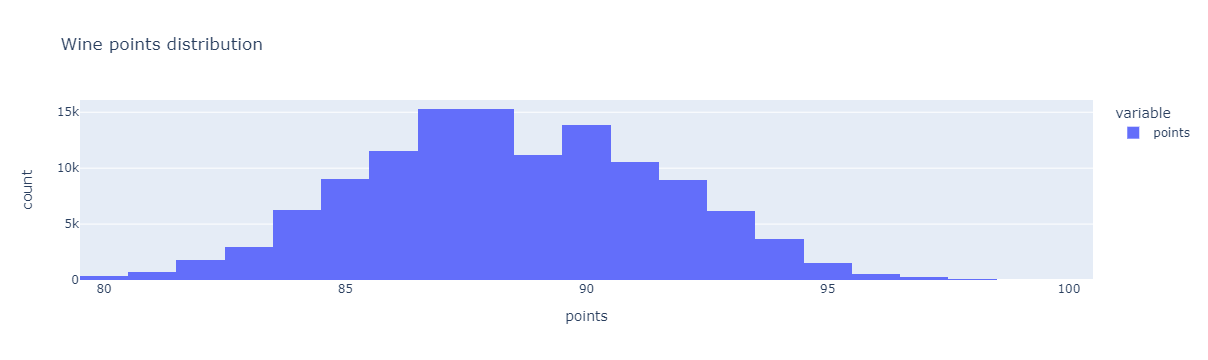

In [39]:
display(desc.points.value_counts().sort_index())
px.histogram(desc.points, labels={"value":"points"}, title="Wine points distribution")

In [40]:
desc

,description,points
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87
...,...,...
129966,Notes of honeysuckle and cantaloupe sweeten th...,90
129967,Citation is given as much as a decade of bottl...,90
129968,Well-drained gravel soil gives this wine its c...,90
129969,"A dry style of Pinot Gris, this is crisp with ...",90


In [41]:
import string
import emoji
import re as regex

In [42]:
specialChars = ''.join([",", ":", "\"", "=", "&", ";", "%", "$","@", "%", "^", "*", "(", ")", "{", "}",'–','“', '”'
                      "[", "]", "|", "/", "\\", ">", "<", "-","!", "?", ".", "'","--", "---", "#", '‘', '’', '…'])  
space_chars = ['.',',',';', '&', '?','!']
def remove_by_regex(text, regexp):
    return text.replace(regexp, "")

def remove_urls(text):
    return remove_by_regex(text, regex.compile(r"http\S+"))

def remove_special_chars(text): 
    return text.apply(lambda text: ''.join([c for c in text if c not in specialChars]))

def remove_usernames(text):
    return remove_by_regex(text, regex.compile(r"@[^\s]+[\s]?"))

def remove_numbers(text):
    return remove_by_regex(text, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

def remove_emojis(text):
    return text.apply(lambda text: ''.join(c for c in text if c not in emoji.UNICODE_EMOJI))

def add_spaces(text):
    def add_spaces_int(text):
        for char in space_chars:
            text = text.replace(char, char + ' ')
        return text
    return text.apply(lambda text: add_spaces_int(text))

def leave_language_only(text):
    for f in [remove_urls, remove_emojis, add_spaces, remove_numbers, remove_usernames, remove_special_chars]:
        text = f(text)
    return text

In [43]:
desc['pureTextDescription'] = leave_language_only(desc.description.str.lower())
desc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119988 entries, 0 to 129970
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   description          119988 non-null  object
 1   points               119988 non-null  int64 
 2   pureTextDescription  119988 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


In [44]:
desc[['description','pureTextDescription']].sample(3)

,description,pureTextDescription
85026,"Very young, very tannic, this wine is hard and...",very young very tannic this wine is hard and...
13653,"Round rather than racy, this fruity effort rin...",round rather than racy this fruity effort rin...
112950,Aromas of exotic fruit and candied citrus zest...,aromas of exotic fruit and candied citrus zest...


Split to train & test samples:

In [45]:
train_desc = desc.sample(frac = 0.8)
test_desc = desc[~desc.index.isin(train_desc.index)]

In [46]:
len(train_desc) + len(test_desc) == len(desc)

True

In [47]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [48]:
stopwords=nltk.corpus.stopwords.words("english") + nltk.corpus.stopwords.words("italian") + nltk.corpus.stopwords.words("spanish")

In [49]:
# desc['original_lower_cased_description'] = desc.description.str.lower()
all_words = [word for description in train_desc.pureTextDescription for word in nltk.word_tokenize(description) if word not in stopwords] # Words without stop words

In [50]:
words_df = pd.DataFrame(data = all_words, columns = ['word']).word.value_counts().reset_index()
words_df.columns = ['word','wordCount']
words_df['wordImportance'] = len(words_df) / words_df.wordCount / words_df.wordCount.max()
words_df.head()

,word,wordCount,wordImportance
0,wine,57820,0.000012
1,flavors,46272,0.000015
2,fruit,33347,0.000021
3,aromas,28931,0.000024
4,palate,27710,0.000025


In [51]:
test_words = [word for description in test_desc.pureTextDescription for word in nltk.word_tokenize(description) if word not in stopwords] # Words without stop words
test_words_df = pd.DataFrame(data = test_words, columns = ['word']).word.value_counts().reset_index()
test_words_df.columns = ['word','wordCount']
test_words_df['wordImportance'] = len(test_words_df) / test_words_df.wordCount / test_words_df.wordCount.max()
test_words_df.head()

,word,wordCount,wordImportance
0,wine,14337,0.000100
1,flavors,11686,0.000123
2,fruit,8228,0.000174
3,aromas,7311,0.000196
4,palate,7016,0.000204


In [52]:
import numpy as np

In [53]:
np.logspace(-2, 4, num=50, endpoint=True, base=10.0)

array([1.00000000e-02, 1.32571137e-02, 1.75751062e-02, 2.32995181e-02,
       3.08884360e-02, 4.09491506e-02, 5.42867544e-02, 7.19685673e-02,
       9.54095476e-02, 1.26485522e-01, 1.67683294e-01, 2.22299648e-01,
       2.94705170e-01, 3.90693994e-01, 5.17947468e-01, 6.86648845e-01,
       9.10298178e-01, 1.20679264e+00, 1.59985872e+00, 2.12095089e+00,
       2.81176870e+00, 3.72759372e+00, 4.94171336e+00, 6.55128557e+00,
       8.68511374e+00, 1.15139540e+01, 1.52641797e+01, 2.02358965e+01,
       2.68269580e+01, 3.55648031e+01, 4.71486636e+01, 6.25055193e+01,
       8.28642773e+01, 1.09854114e+02, 1.45634848e+02, 1.93069773e+02,
       2.55954792e+02, 3.39322177e+02, 4.49843267e+02, 5.96362332e+02,
       7.90604321e+02, 1.04811313e+03, 1.38949549e+03, 1.84206997e+03,
       2.44205309e+03, 3.23745754e+03, 4.29193426e+03, 5.68986603e+03,
       7.54312006e+03, 1.00000000e+04])

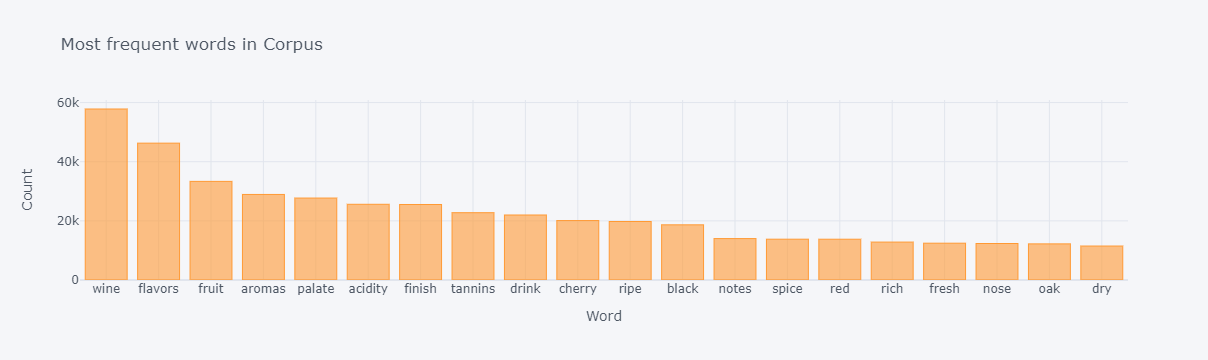

In [54]:
words_df.set_index('word').wordCount.head(20).iplot(kind = 'bar', title = 'Most frequent words in Corpus', yTitle = 'Count', xTitle = 'Word')

In [55]:
print("Total of {} words, {} unique words".format(len(all_words), len(words_df)))

Total of 2359682 words, 40112 unique words


to reduce the corpus size more, we probably don't care about words that appear to little. Let's drop any word which have under 5 appearnces:

In [56]:
print ("Using words with 5 or more appearnces will reduce the corpus size to: {}".format(sum(words_df.wordCount >= 5)))

Using words with 5 or more appearnces will reduce the corpus size to: 11683


In [57]:
words_df = words_df[words_df.wordCount >= 5]

### Bag of words (One-hot-encoding)

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [59]:
clean_vocab = set(words_df.word)
count_vect = CountVectorizer(vocabulary = clean_vocab, tokenizer=nltk.word_tokenize)
clean_bow_counts = count_vect.fit_transform(train_desc.pureTextDescription)
clean_bow_counts.shape

(95990, 11683)

In [60]:
train_desc.iloc[1].pureTextDescription

'dark  meaty and mellow on the nose  with blackberry and a distant hint of tomato leaf  its a fraction candied and scratchy in the mouth  but the mildly herbal plum and cherry flavors are solid  sweet and slightly smoky on the finish  with fading substance the longer it goes '

In [61]:
print(clean_bow_counts[1])

  (0, 920)	1
  (0, 1448)	1
  (0, 1744)	1
  (0, 2619)	1
  (0, 2940)	1
  (0, 3622)	1
  (0, 3800)	1
  (0, 3873)	1
  (0, 4041)	1
  (0, 4411)	1
  (0, 4805)	1
  (0, 4867)	1
  (0, 5597)	1
  (0, 5855)	1
  (0, 6209)	1
  (0, 6254)	1
  (0, 6368)	1
  (0, 6557)	1
  (0, 6825)	1
  (0, 7629)	1
  (0, 8918)	1
  (0, 9345)	1
  (0, 9391)	1
  (0, 9455)	1
  (0, 9917)	1
  (0, 10100)	1
  (0, 10526)	1


In [62]:
test_clean_vocab = set(test_words_df.word)
test_count_vect = CountVectorizer(vocabulary = test_clean_vocab, tokenizer=nltk.word_tokenize)
test_clean_bow_counts = count_vect.fit_transform(test_desc.pureTextDescription)
test_clean_bow_counts.shape

(23998, 11683)

In [63]:
rev_dict = {v:k for k,v in count_vect.vocabulary_.items()}
print(rev_dict[236])
print(rev_dict[470])
print(rev_dict[851])
print(rev_dict[866])

alongside
artisanal
best
biancolella


In [64]:
clean_bow_counts.sum()

2315810

In [65]:
tf_idf_vectorizer = TfidfVectorizer(vocabulary = clean_vocab)
bow_tfidf = tf_idf_vectorizer.fit_transform(train_desc.pureTextDescription)
bow_tfidf.shape

(95990, 11683)

In [66]:
bow_tfidf.sum()

431413.8831930941

In [67]:
print(clean_bow_counts[1])

  (0, 920)	1
  (0, 1448)	1
  (0, 1744)	1
  (0, 2619)	1
  (0, 2940)	1
  (0, 3622)	1
  (0, 3800)	1
  (0, 3873)	1
  (0, 4041)	1
  (0, 4411)	1
  (0, 4805)	1
  (0, 4867)	1
  (0, 5597)	1
  (0, 5855)	1
  (0, 6209)	1
  (0, 6254)	1
  (0, 6368)	1
  (0, 6557)	1
  (0, 6825)	1
  (0, 7629)	1
  (0, 8918)	1
  (0, 9345)	1
  (0, 9391)	1
  (0, 9455)	1
  (0, 9917)	1
  (0, 10100)	1
  (0, 10526)	1


## Regression

In [68]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [69]:
from sklearn.model_selection import cross_validate

In [70]:
from sklearn.linear_model import Ridge # LogisticRegression
# from sklearn.linear_model import ElasticNet # LogisticRegression

### Regulatization Strength

In [71]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

In [72]:
train_desc.head()

,description,points,pureTextDescription
33317,"Here's a slightly sweet, warm-climate white wi...",84,heres a slightly sweet warmclimate white with...
19232,"Dark, meaty and mellow on the nose, with black...",86,dark meaty and mellow on the nose with black...
87845,"This blend, which is mainly Zinfandel and Cabe...",88,this blend which is mainly zinfandel and cabe...
33095,"A blend of 60% Syrah, 25% Grenache and 15% Car...",88,a blend of syrah grenache and carignan meaty...
60862,"Too sharp in acids, giving the cherry and rasp...",82,too sharp in acids giving the cherry and rasp...


In [73]:
%%capture
search_grid = np.logspace(0, 2, num=40, endpoint=True, base=10.0)
mse_by_alpha, r2_by_alpha, mae_by_alpha = [], [], []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    # avg_score = cross_val_score(model, clean_bow_counts, y = desc.points, cv = 10, scoring = 'neg_mean_squared_error', error_score='raise').mean()
    # avg_score = np.abs(avg_score)
    # mse_by_alpha.append((alpha,avg_score))
    cv_results = cross_validate(model, clean_bow_counts, y = train_desc.points, cv = 10, scoring = ['neg_mean_squared_error','r2','neg_mean_absolute_error'], error_score='raise')
    
    avg_mse = np.abs(cv_results['test_neg_mean_squared_error'].mean())
    avg_r2 = cv_results['test_r2'].mean()
    avg_mae = np.abs(cv_results['test_neg_mean_absolute_error'].mean())
    
    mse_by_alpha.append((alpha,avg_mse))
    mae_by_alpha.append((alpha,avg_mae))
    r2_by_alpha.append((alpha,avg_r2))

    # break

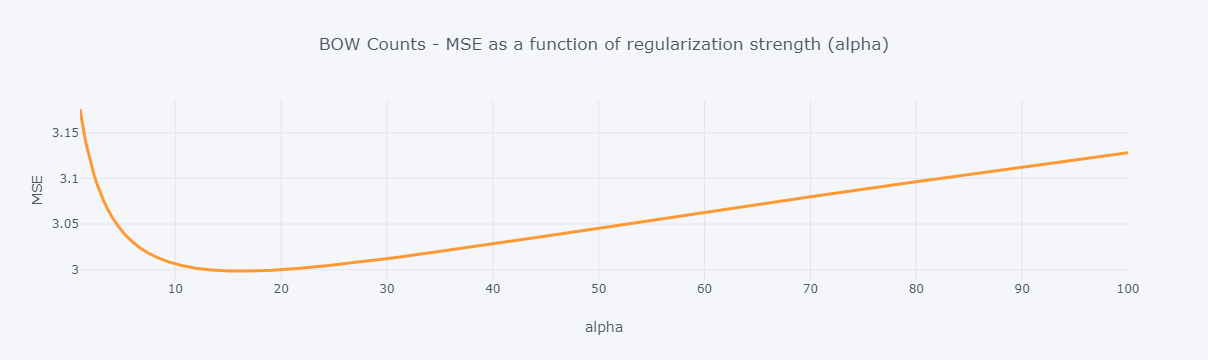

In [74]:
cv_results_mse = pd.DataFrame(mse_by_alpha, columns = ['alpha', 'MSE'])
cv_results_mse.set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of regularization strength (alpha)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

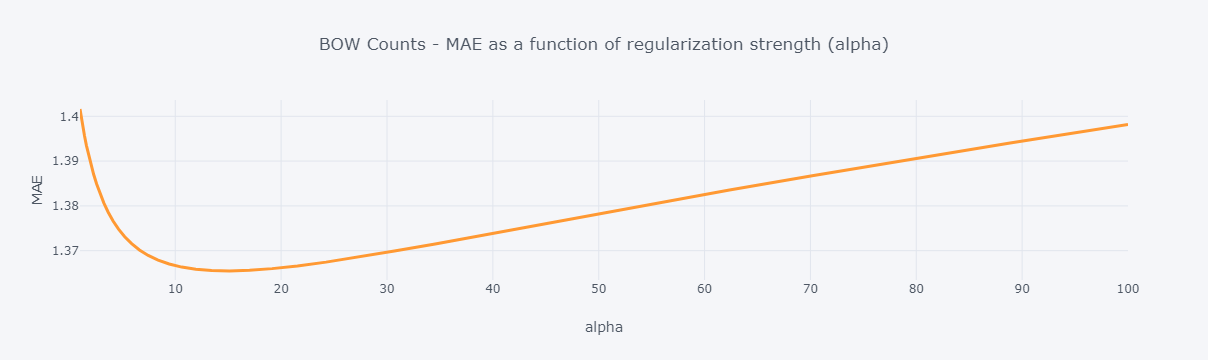

In [75]:
cv_results_mae = pd.DataFrame(mae_by_alpha, columns = ['alpha', 'MAE'])
cv_results_mae.set_index('alpha').MAE.iplot(title = 'BOW Counts - MAE as a function of regularization strength (alpha)', xTitle = 'alpha', yTitle = 'MAE', width = 3, hline=(0,0))

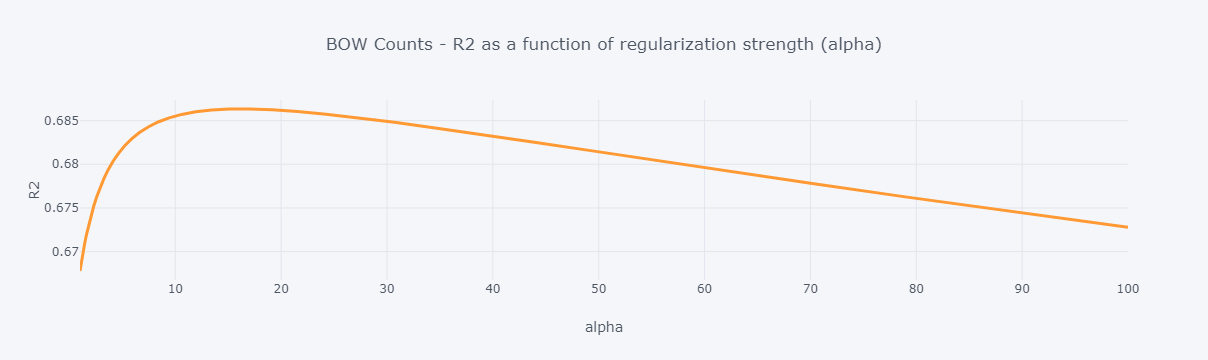

In [76]:
cv_results_r2 = pd.DataFrame(r2_by_alpha, columns = ['alpha', 'R2'])
cv_results_r2.set_index('alpha').R2.iplot(title = 'BOW Counts - R2 as a function of regularization strength (alpha)', xTitle = 'alpha', yTitle = 'R2', width = 3, hline=(0,0))

In [77]:
cv_results = pd.concat([cv_results_mse, cv_results_mae, cv_results_r2],axis=1)
assert cv_results.iloc[:,0].compare(cv_results.iloc[:,2]).empty and cv_results.iloc[:,0].compare(cv_results.iloc[:,4]).empty
cv_results = cv_results[["alpha","MSE","MAE","R2"]]
cv_results = cv_results.iloc[:,2:]
cv_results.head()

,alpha,MSE,MAE,R2
0,1.000000,3.176014,1.401630,0.667781
1,1.125336,3.166489,1.399674,0.668777
2,1.266380,3.156843,1.397697,0.669786
3,1.425103,3.147010,1.395658,0.670814
4,1.603719,3.136666,1.393525,0.671896


In [78]:
cv_results.loc[cv_results.R2.idxmax()]

alpha    17.012543
MSE       2.998607
MAE       1.365614
R2        0.686331
Name: 24, dtype: float64

In [79]:
cv_results.loc[cv_results.MSE.idxmin()]

alpha    17.012543
MSE       2.998607
MAE       1.365614
R2        0.686331
Name: 24, dtype: float64

In [80]:
cv_results.loc[cv_results.MAE.idxmin()]

alpha    15.117751
MSE       2.998637
MAE       1.365458
R2        0.686328
Name: 23, dtype: float64

In [81]:
opt_alpha = float(cv_results.loc[cv_results.MSE.idxmin(),"alpha"])
opt_alpha

17.012542798525892

### Optimal Model

Let's use the optimal model regularization parameter and train a model on the **entire dataset**:

In [82]:
model = Ridge(alpha=opt_alpha) #LogisticRegression(penalty='l2', C=(1/opt_alpha))
model.fit(clean_bow_counts, train_desc.points)

Ridge(alpha=17.012542798525892)

In [83]:
train_desc['predicted_points'] = model.predict(clean_bow_counts)

In [84]:
# accuracy_score(df.predicted_class, df.cls) # Training accuracy, for sanity only
mean_squared_error(train_desc.points, train_desc.predicted_points), mean_absolute_error(train_desc.points, train_desc.predicted_points), r2_score(train_desc.points, train_desc.predicted_points)

(2.5813758955253254, 1.2691719031639521, 0.730002271389856)

In [85]:
test_clean_bow_counts

<23998x11683 sparse matrix of type '<class 'numpy.int64'>'
	with 561626 stored elements in Compressed Sparse Row format>

In [87]:
# model = Ridge(alpha=opt_alpha)
# model.fit(test_clean_bow_counts, test_desc.points)
test_desc['predicted_points'] = model.predict(test_clean_bow_counts)
BOW_stats = mean_squared_error(test_desc.points, test_desc.predicted_points), mean_absolute_error(test_desc.points, test_desc.predicted_points), r2_score(test_desc.points, test_desc.predicted_points)
BOW_stats

(2.958995218822695, 1.3573239341802292, 0.6913345482410219)

In [88]:
BOW_stats = pd.Series(data=BOW_stats, index=["MSE","MAE","R2"])
BOW_stats

MSE    2.958995
MAE    1.357324
R2     0.691335
dtype: float64

### Feature importance

In [89]:
weights = model.coef_.flatten()
words = [rev_dict[i] for i in range(len(weights))]
feature_weights = pd.DataFrame({'word': words, 'weight': weights, 'absW': abs(weights)})
feature_weights.sort_values(by = 'absW', ascending = False, inplace = True)
feature_weights.head(5)

,word,weight,absW
8767,sample,3.033877,3.033877
5865,longterm,1.463060,1.463060
11680,—m,-1.424045,1.424045
757,beautiful,1.343582,1.343582
9814,strange,-1.332343,1.332343


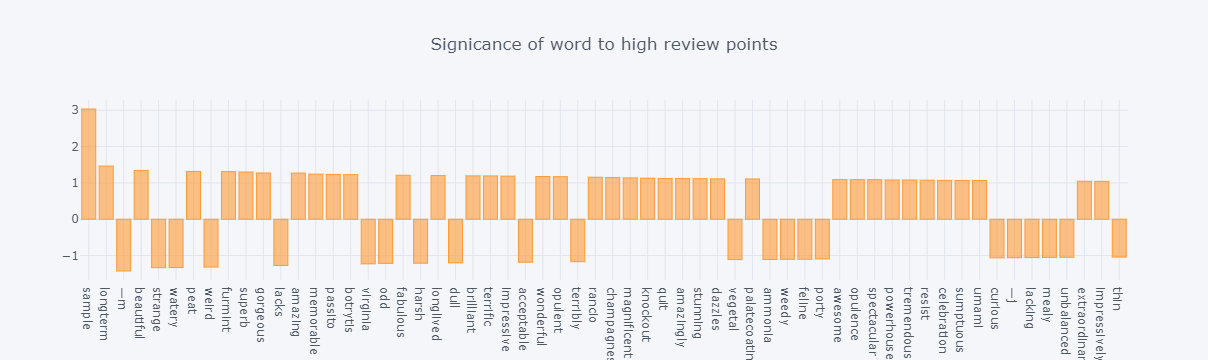

In [90]:
feature_weights.set_index('word').weight.head(60).iplot(kind = 'bar', title = 'Signicance of word to high review points', hline=(0,0))

In [91]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats,BOW_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb',"BOW"])
all_compared

,MSE,MAE,R2
baseline_1,9.531632,2.534622,-0.000007
baseline_2,9.062183,2.466627,0.049245
baseline_3,8.482525,2.368011,0.110060
regression_by_xgb,6.201267,1.888907,0.349397
BOW,2.958995,1.357324,0.691335


<div class="alert alert-block alert-warning">
<span style='background :white'> 
<span style='color:Blue'> <i>
    <b>
        ~ Done! ~
    </b>
    </i>  </span>
  </span>
    </div>

### Using both the text and other features

## DATA PREP

In [187]:
categorical_features = ['country','province','region_1','region_2','taster_name','variety','winery']
numerical_features = ['price']
features = categorical_features + numerical_features

In [188]:
encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded_features['points'] = wine_reviews.points
encoded_features.head(2)

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87
1,32,108,738,6,16,451,12956,15.0,87


In [189]:
#replacing null price with more accurate mean (by features: country, province...)
# slices done using NA count per feature - wine_reviews.info()
wines = wine_reviews.copy()
print(wines.price.isna().sum())
wines['price'] = wines['price'].fillna(wines.groupby(['country', 'province', 'region_1', 'region_2', 'winery', 'variety'])['price'].transform('mean'))
print(wines.price.isna().sum())
wines['price'] = wines['price'].fillna(wines.groupby(['country', 'province', 'region_1', 'winery', 'variety'])['price'].transform('mean'))
print(wines.price.isna().sum())
wines['price'] = wines['price'].fillna(wines.groupby(['country', 'province', 'winery', 'variety'])['price'].transform('mean'))
print(wines.price.isna().sum())
wines['price'] = wines['price'].fillna(wines.groupby(['country', 'winery', 'variety'])['price'].transform('mean'))
print(wines.price.isna().sum())
wines['price'] = wines['price'].fillna(wines.groupby(['country', 'winery'])['price'].transform('mean'))
print(wines.price.isna().sum())
wines['price'] = wines['price'].fillna(wines.groupby(['country', 'variety'])['price'].transform('mean'))
print(wines.price.isna().sum())
wines['price'] = wines.price.fillna(wines.price.mean())
print(wines.price.isna().sum())

8395
8270
4263
2675
2558
1584
11
0


In [190]:
#encoding wines df with replaced mean
encoded = wines[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
#encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded['price'] = wines.price
encoded['points'] = wines.points
encoded.head(2)

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,19.0,87
1,32,108,738,6,16,451,12956,15.0,87


In [191]:
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(wine_reviews))

In [192]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hagai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hagai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hagai\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [193]:
#1 break the wines description to tokens using nltk.word_tokenize
wines = wine_reviews.copy()
wines['description_lowercase'] = wines.description.apply(lambda desc: desc.lower())
wines['desc_tokens'] = wines.description_lowercase.apply(lambda desc: nltk.word_tokenize(desc))
#remove punctuation
wines['desc_tokens'] = wines.desc_tokens.apply(lambda words: [word for word in words if word.isalnum()])

In [194]:
wines[['desc_tokens', 'description_lowercase']].sample(2)

,desc_tokens,description_lowercase
117200,"[light, earthy, scents, of, brambly, berry, ch...","light, earthy scents of brambly berry, cherry,..."
17863,"[a, very, oaky, nose, leads, into, a, tough, t...","a very oaky nose leads into a tough, tannic wi..."


In [195]:
############ resplitting wines to train and test
train_data = wines[wines.index.isin(train_data.index)]
test_data = wines[wines.index.isin(test_data.index)]
assert(train_data.shape[0] + test_data.shape[0]  == wines.shape[0])

In [196]:
####building the vocab only from training
#2 words wo stopwords to list
stopwords=nltk.corpus.stopwords.words("english")
all_words = [word for lst in wines.desc_tokens for word in lst if word.lower() not in stopwords] # Words without stop words
####building the vocab only from training
trn_words = [word for lst in train_data.desc_tokens for word in lst if word.lower() not in stopwords]

In [197]:
####building the vocab only from training
#3 create df + count the apperances
words_df = pd.DataFrame(data = trn_words, columns = ['word']).word.value_counts().reset_index()
words_df.columns = ['word','wordCount']

In [198]:
words_df['wordImportance'] = len(words_df) / words_df.wordCount / words_df.wordCount.max()
# print(words_df.loc[0])
# print(len(words_df), words_df.wordCount[0], words_df.wordCount.max())
words_df.head(3)

,word,wordCount,wordImportance
0,wine,59223,0.000008
1,flavors,46338,0.000010
2,fruit,33334,0.000014


In [199]:
#defining the vocabulary:
#from train data only and appeared n_appear or above
#choosing 5 - as smaller may lead to overfit
n_appear = 5
vocab = set(words_df[words_df.wordCount >= n_appear].word) #set of all the words in vocab that appear n_appear or more

In [200]:
# sparse matrixes from train and test df
count_vect = CountVectorizer(vocabulary = vocab, tokenizer=nltk.word_tokenize)
train_bow_counts = count_vect.fit_transform(train_data.description_lowercase)
test_bow_counts = count_vect.fit_transform(test_data.description_lowercase)
assert(train_bow_counts.shape[0] + test_bow_counts.shape[0]  == wines.shape[0])
print('train:', train_bow_counts.shape[0], ' + test:',test_bow_counts.shape[0], ' = ', wines.shape[0])

train: 95990  + test: 23998  =  119988


In [201]:
print(train_data.iloc[1].desc_tokens)
#reverse dictionary rev_dict[word_num] ->word - print some examples:
rev_dict = {v:k for k,v in count_vect.vocabulary_.items()}
print(rev_dict[78])
print(rev_dict[260])
print(rev_dict[9040])
print(rev_dict[9348])
print(rev_dict[10426])

['pineapple', 'rind', 'lemon', 'pith', 'and', 'orange', 'blossom', 'start', 'off', 'the', 'aromas', 'the', 'palate', 'is', 'a', 'bit', 'more', 'opulent', 'with', 'notes', 'of', 'guava', 'and', 'mango', 'giving', 'way', 'to', 'a', 'slightly', 'astringent', 'semidry', 'finish']
2019
acidity
sturdy
tartness
without


In [202]:
### resplitting encoded to train and test
train_enc = encoded_features[encoded_features.index.isin(train_data.index)].iloc[:,0:8]
test_enc = encoded_features[encoded_features.index.isin(test_data.index)].iloc[:,0:8]
assert(train_enc.shape[0] + test_enc.shape[0]  == encoded_features.shape[0])

In [203]:
### combining sparse encoded features with bow
from scipy.sparse import coo_matrix, hstack

train_features_sparse = coo_matrix(train_enc) #constract sparse matrix from encoded df (next step to concat with BoW)
train_united_features = hstack((train_features_sparse, train_bow_counts)) #stack arrays in sequence horizontally (col wise) - aka concat the 6 features with 2030
test_features_sparse = coo_matrix(test_enc) #constract sparse matrix from encoded df (next step to concat with BoW)
test_united_features = hstack((test_features_sparse, test_bow_counts)) #stack arrays in sequence horizontally (col wise) - aka concat the 6 features with 2030
assert(train_united_features.shape[0] + test_united_features.shape[0]  == encoded_features.shape[0])
print('train:', train_united_features.shape, ' + test:',test_united_features.shape, ' = ', encoded_features.shape)

train: (95990, 10571)  + test: (23998, 10571)  =  (119988, 9)


## END DATA PREP

In [204]:
train_enc.head()

,country,province,region_1,region_2,taster_name,variety,winery,price
1,32,108,738,6,16,451,12956,15.0
3,41,218,549,6,0,480,14390,13.0
4,41,269,1218,17,15,441,14621,65.0
5,38,263,758,6,12,591,14706,15.0
6,22,332,1205,6,9,186,15014,16.0


In [205]:
opt_alpha=12.915496650148826

In [206]:
#run fit using train bow sparse matrix
#using opt_alpha from above
united_lreg = Ridge(alpha=opt_alpha, tol=1e-4)
united_lreg.fit(train_united_features, y = train_data.points)

Ridge(alpha=12.915496650148826, tol=0.0001)

In [207]:
#use model to predict using test bow sparse matrix
united_lreg_test = test_data.copy()
united_lreg_test['united_lin_reg'] = united_lreg.predict(test_united_features)
#united_lreg_test.sample(1)

In [208]:
calc_prediction_quality(united_lreg_test, 'united_lin_reg','points')

MSE    2.879354
MAE    1.334246
R2     0.697914
dtype: float64

## STOP H TEST

Search grid with higher granularity around the the area suspected to yield best results:

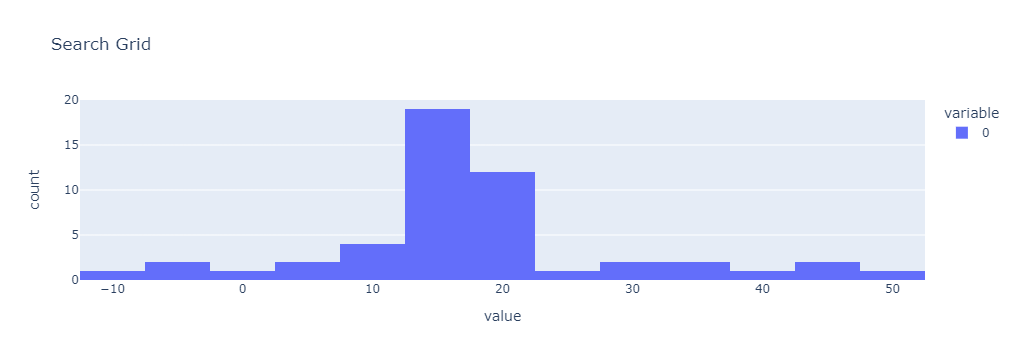

array([-10.        ,  -6.84210526,  -3.68421053,  -0.52631579,
         2.63157895,   5.78947368,   8.94736842,  12.        ,
        12.10526316,  12.27586207,  12.55172414,  12.82758621,
        13.10344828,  13.37931034,  13.65517241,  13.93103448,
        14.20689655,  14.48275862,  14.75862069,  15.03448276,
        15.26315789,  15.31034483,  15.5862069 ,  15.86206897,
        16.13793103,  16.4137931 ,  16.68965517,  16.96551724,
        17.24137931,  17.51724138,  17.79310345,  18.06896552,
        18.34482759,  18.42105263,  18.62068966,  18.89655172,
        19.17241379,  19.44827586,  19.72413793,  20.        ,
        21.57894737,  24.73684211,  27.89473684,  31.05263158,
        34.21052632,  37.36842105,  40.52631579,  43.68421053,
        46.84210526,  50.        ])

In [209]:
search_grid1 = np.linspace(-10, 50, num=20, endpoint=True)
search_grid2 = np.linspace(12, 20, num=30, endpoint=True)

search_grid3 = np.concatenate((search_grid1, search_grid2))
search_grid3.sort()
search_grid = search_grid3
fig = px.histogram(search_grid, title="Search Grid")
fig.show()
search_grid

In [210]:
%%capture
# search_grid = [0,0.03,0.1,0.3,1,5,15,45,150,500,1500]#,np.logspace(0, 6, num=50, endpoint=True, base=10.0)
mse_by_alpha, r2_by_alpha, mae_by_alpha = [], [], []
for alpha in search_grid:
    model = Ridge(alpha=alpha, tol=0.00001, max_iter=100000)
    # avg_score = cross_val_score(model, train_united_features, y = df.cls, cv = 10, scoring = 'roc_auc').mean()
    # auc_by_alpha.append((alpha,avg_score))
    
    cv_results = cross_validate(model, train_united_features, y = train_data.points, cv = 10, scoring = ['neg_mean_squared_error','r2','neg_mean_absolute_error'], error_score='raise')
    
    avg_mse = np.abs(cv_results['test_neg_mean_squared_error'].mean())
    avg_r2 = cv_results['test_r2'].mean()
    avg_mae = np.abs(cv_results['test_neg_mean_absolute_error'].mean())
    
    mse_by_alpha.append((alpha,avg_mse))
    mae_by_alpha.append((alpha,avg_mae))
    r2_by_alpha.append((alpha,avg_r2))

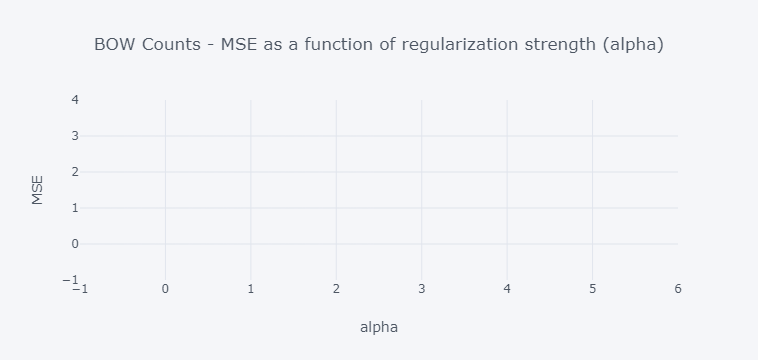

In [211]:
cv_results_mse = pd.DataFrame(mse_by_alpha, columns = ['alpha', 'MSE'])
cv_results_mse.set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of regularization strength (alpha)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

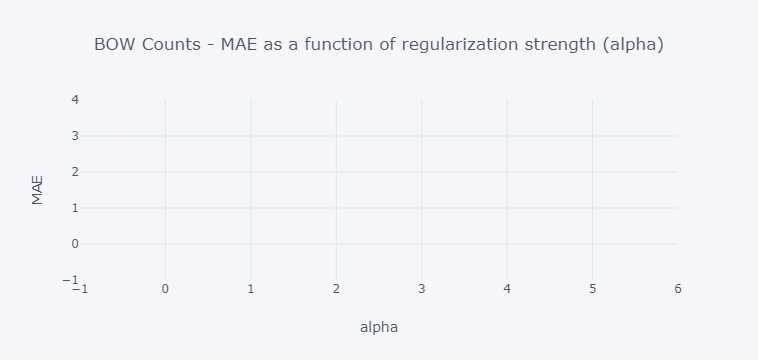

In [212]:
cv_results_mae = pd.DataFrame(mae_by_alpha, columns = ['alpha', 'MAE'])
cv_results_mae.set_index('alpha').MAE.iplot(title = 'BOW Counts - MAE as a function of regularization strength (alpha)', xTitle = 'alpha', yTitle = 'MAE', width = 3, hline=(0,0))

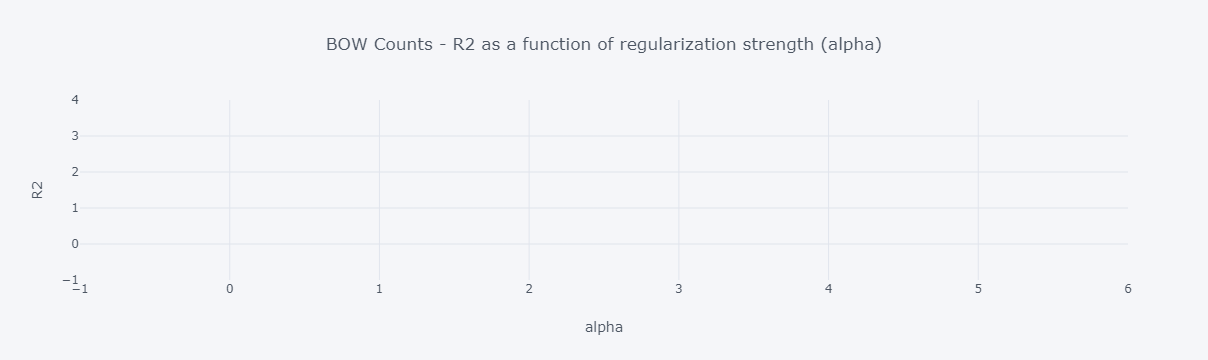

In [213]:
cv_results_r2 = pd.DataFrame(r2_by_alpha, columns = ['alpha', 'R2'])
cv_results_r2.set_index('alpha').R2.iplot(title = 'BOW Counts - R2 as a function of regularization strength (alpha)', xTitle = 'alpha', yTitle = 'R2', width = 3, hline=(0,0))

If all features are not better than TEXT alone - use all features, but with text-predicted-score instead of TEXT.

In [214]:
cv_results = pd.concat([cv_results_mse, cv_results_mae, cv_results_r2],axis=1)
assert cv_results.iloc[:,0].compare(cv_results.iloc[:,2]).empty and cv_results.iloc[:,0].compare(cv_results.iloc[:,4]).empty
cv_results = cv_results[["alpha","MSE","MAE","R2"]]
cv_results = cv_results.iloc[:,2:]
cv_results.head()

,alpha,MSE,MAE,R2


In [215]:
cv_results.loc[cv_results.MSE.idxmin()]

TypeError: reduction operation 'argmin' not allowed for this dtype

In [ ]:
cv_results.loc[cv_results.MAE.idxmin()]

In [ ]:
cv_results.loc[cv_results.R2.idxmax()]

In [ ]:
opt_alpha = float(cv_results.loc[cv_results.MSE.idxmin(),"alpha"])
opt_alpha

Test with optimal alpha:

In [ ]:
model = Ridge(alpha=opt_alpha, tol=0.00001, max_iter=100000)
model.fit(train_united_features, train_data.points)

In [ ]:
train_data['predicted_points'] = model.predict(train_united_features)

In [ ]:
mean_squared_error(train_data.points, train_data.predicted_points), mean_absolute_error(train_data.points, train_data.predicted_points), r2_score(train_data.points, train_data.predicted_points)

In [ ]:
test_data['predicted_points'] = model.predict(test_united_features)
NLP_all_features_stats = mean_squared_error(test_data.points, test_data.predicted_points), mean_absolute_error(test_data.points, test_data.predicted_points), r2_score(test_data.points, test_data.predicted_points)
NLP_all_features_stats

In [ ]:
NLP_all_features_stats = pd.Series(data=NLP_all_features_stats, index=["MSE","MAE","R2"])
NLP_all_features_stats

In [ ]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats,BOW_stats,NLP_all_features_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb',"BOW","NLP all features"])
all_compared

<div class="alert alert-block alert-warning">
<span style='background :white'> 
<span style='color:Blue'> <i>
    <b>
        ~ Done! ~
    </b>
    </i>  </span>
  </span>
    </div>

## Deep Learning approaches

### Fully connected network on the text only

#### Tokenization

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

What is a good size for the vocabulary? 

In [ ]:
wine_reviews.description.apply(lambda x: len(x.split(' '))).quantile([0.95, 0.99])

In [ ]:
vocab_size = 32000
sequence_length = 60

# Use the text vectorization layer to normalize, split, and map strings to integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    standardize='lower_and_strip_punctuation', # Or you can use a pre-made normalization function
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

In [ ]:
vectorize_layer.adapt(train_data['description'])

In [ ]:
sample_description = train_data['description'].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

In [ ]:
for token in vectorize_layer(sample_description).numpy()[:20]:
    print(f"{token} ---> ",vectorize_layer.get_vocabulary()[token])

#### Modeling

In [ ]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [ ]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

### Simple NN Prediction & Evaluation

In [ ]:
test_data['dnn_prediction'] = model.predict(test_data[text_col])

In [ ]:
DNN_text_only_Average = calc_prediction_quality(test_data, 'dnn_prediction', target_col)
DNN_text_only_Average

In [ ]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats,BOW_stats,NLP_all_features_stats,DNN_text_only_Average], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb',"BOW","NLP all features", "DNN_text_only_Average"])
all_compared

### Descriptions words concatinated

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Dense, Dropout, Embedding
from tensorflow.keras import Sequential

In [ ]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding", ),
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.7),
    Dense(1, name = 'output_layer')
])

In [ ]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [ ]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [ ]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

In [ ]:
test_data['dnn_prediction'] = model.predict(test_data[text_col])

In [ ]:
DNN_text_only_Concat = calc_prediction_quality(test_data, 'dnn_prediction', target_col)
DNN_text_only_Concat

In [ ]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats,BOW_stats,NLP_all_features_stats,DNN_text_only_Average,DNN_text_only_Concat], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb',"BOW","NLP all features", "DNN_text_only_Average","DNN_text_only_Concat"])
all_compared

### Using external embedding (description feature only)

Follow https://keras.io/examples/nlp/pretrained_word_embeddings/

You can either average the description words embeddings, concatinate them or do both and compare. 

#### Load pre-trained word embeddings

In [ ]:
import os
import numpy as np

External embeddings source:
    https://github.com/stanfordnlp/GloVe
    (download and extract to appropriate path)

In [ ]:
filename = "glove.840B.300d.txt" 
mypth = os.getcwd()
path_to_glove_file = mypth + "\\data\\" + filename
path_to_glove_file

#### dict mapping words (strings) to their NumPy vector representation:

In [ ]:
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

#### prepare embedding matrix 

In [ ]:
vocab = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

In [ ]:
train_data.head()

In [ ]:
sample_description = train_data['description_lowercase'].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

In [ ]:
num_tokens = len(vocab) + 2

embedding_dim = 300 # external embeddings has 300 dimensions
hits = 0
misses = 0

# Prepare embedding matrix
missing_words = []
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and len(embedding_vector)!=0:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        if len(embedding_vector)!=300:
            print("hits =",hits)
            print(len(embedding_vector))
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        missing_words.append(word)
print("Converted %d words (%d misses)" % (hits, misses))

In [ ]:
#Examples of words in wines review that are NOT in the external vocabulary
if misses > 0:
    misses_i =np.min([misses-1,20])
    print(missing_words[0:misses_i])

In [ ]:
substr = 'redfruit'
wines[wines.description.apply(lambda desc: True if substr in desc else False)].iloc[0,:].to_frame()

In [ ]:
wines.description_lowercase.iloc[59252]

#### Create Embedding Layer

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
#    trainable=True,
)
# trainable=False so as to keep the embeddings fixed; True - will continue learning (very slow - high dim!)

#### Building the model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Dense, Dropout, Embedding
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
nn = 820
ndropout = 0.2
nbatch = 32
nepochs = 30
mloss = 'mse'
n_lr = 3e-4
active_f = 'tanh'

In [ ]:
#create model
#using reshape to concat the vectors - should add also more info on order of words
#replaced embedding layer with pre-build embedding built using Glove external embedding
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(nn, activation=active_f, name='hidden_layer'),
    Dropout(ndropout),
    Dense(1, name = 'output_layer')
])

In [ ]:
optimizer = Adam(learning_rate=n_lr)
model.compile(loss=mloss, optimizer=optimizer, metrics=['mean_squared_error','mean_absolute_error'])

In [ ]:
model.summary()

In [ ]:
# pip install pydot

In [ ]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [ ]:
# # Approximately 20 minutes
%%time
text_col, target_col = 'description_lowercase', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=nepochs,
    batch_size=nbatch,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

In [ ]:
test_data['ext_embedding'] = model.predict(test_data[text_col])

In [ ]:
px.scatter(history.history["loss"],  trendline="lowess")

In [ ]:
#check stats and add to comparison df
stats = calc_prediction_quality(test_data, 'ext_embedding', target_col)
stats

In [ ]:
all_compared = all_compared.append(stats.to_frame(name='External_Embeddings_text_only_Concat').transpose())
all_compared

<div class="alert alert-block alert-warning">
<span style='background :white'> 
<span style='color:Blue'> <i>
    <b>
        ~ Done! ~
    </b>
    </i>  </span>
  </span>
    </div>

### Using LSTM or RNN Layer, (description feature only)

See example here: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [ ]:
from keras.layers import LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adamax, Nadam

In [ ]:
#optimized params chosen
embedding_dim = 16
nn = 32
ndropout = 0.2 
active_f = 'tanh'
nbatch  = 64 #32
mloss = 'mse'
n_lr = 3e-3 #3e-4
#
nepochs = 30

#### create model

In [ ]:
#create model with LSTM with Bidirectional wrapper
model = tf.keras.Sequential([
        tf.keras.Input(shape=(1,), dtype=tf.string),
        vectorize_layer,
        Embedding(vocab_size+1, embedding_dim, input_length= sequence_length, name="embedding", mask_zero=True),
        Bidirectional(LSTM(64)),
        Dense(64, activation='relu', name='hidden_layer'),
        Dense(1, name = 'output_layer')
    ])

In [ ]:
optimizer = Adam(learning_rate=n_lr)
model.compile(loss=mloss, optimizer=optimizer, metrics=['mean_squared_error','mean_absolute_error'])

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [ ]:
%%time
text_col, target_col = 'description_lowercase', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=nepochs,
    batch_size=nbatch,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

In [ ]:
test_data['LSTM'] = model.predict(test_data[text_col])

In [ ]:
px.scatter(history.history["loss"],  trendline="lowess")

In [ ]:
#check stats and add to comparison df
stats = calc_prediction_quality(test_data, 'LSTM', target_col)
stats

In [ ]:
all_compared = all_compared.append(stats.to_frame(name='LSTM').transpose())
all_compared

<div class="alert alert-block alert-warning">
<span style='background :white'> 
<span style='color:Blue'> <i>
    <b>
        ~ Done! ~
    </b>
    </i>  </span>
  </span>
    </div>

### Bonus (Not mandatory) Use all features using Keras functional API

See here: https://keras.io/guides/functional_api/

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#model parameters
embedding_dim = 16
nn = 820
ndropout = 0.2
nbatch = 32
nepochs = 10#30#10 #6 #30
mloss = 'mse'
n_lr = 5e-4 #1e-3
active_f = 'tanh'

In [ ]:

#using the kerashape=unctional API to build a model with 2 inputs
#descrption text embedding --- 1st input ---
desc_input = keras.Input(shape=(1,), dtype="string", name="text")
token_input = vectorize_layer(desc_input)
desc_features = layers.Embedding(vocab_size, 16)(token_input)
#desc_features = layers.LSTM(128, name='text_LSTM')(desc_features)
desc_features = Bidirectional(LSTM(64))(desc_features)
desc_features = Dense(64, activation='relu', name='LSTM_hidden')(desc_features)
#other data --- 2nd input ----
other_input = keras.Input(shape=(8,), name="other")
other_features = layers.Dense(32, name="other_hidden")(other_input)
#concatenate --- concat both inputs ---
x = layers.concatenate([desc_features, other_features])
#hidden layer
hidden = layers.Dense(96, name="unified_hidden")(x)
#output
points_pred = layers.Dense(1, name="points_prediction")(hidden)
# Instantiate an end-to-end model from both inputs -> 1 output
model = keras.Model(
    inputs=[desc_input, other_input],
    outputs=[points_pred],
)


In [ ]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

In [ ]:
train_y = encoded_features[encoded_features.index.isin(train_data.index)].points
test_y = encoded_features[encoded_features.index.isin(test_data.index)].points
assert(train_y.shape[0] + test_y.shape[0]  == encoded_features.shape[0])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
if test_enc.shape[1]>8 :
    test_enc = test_enc.iloc[:,:-2]
    # display(test_enc.head())

In [ ]:
#for text data
text_col, target_col = 'description_lowercase', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    #monitor='loss',
    min_delta=0,
    patience=2,#4,#2 #3
    verbose=0,
    restore_best_weights=True
)



In [ ]:
n_lr

In [ ]:
[i/100 for i in [1, 3,10,30]]

In [ ]:
lr_list = [0.01, 0.03, 0.1, 0.3, 1, 3,10,30]
lr_list = [i*n_lr for i in lr_list]
lr_list

In [ ]:
# # approximately 2 hours
# %%time

# results = []

# for learning_rate in lr_list:
#     print("\nLearning rate =",learning_rate,"\n")
    
#     if test_enc.shape[1]>8 :
#         test_enc = test_enc.iloc[:,:-2]
    
#     optimizer = Adam(learning_rate=n_lr)
#     model.compile(loss=mloss, optimizer=optimizer, metrics=['mean_squared_error','mean_absolute_error'])
    
#     history = model.fit(
#         x=[train_data[text_col], train_enc],
#         y=train_y,
#         epochs=nepochs,
#         batch_size=nbatch,
#         verbose=True, 
#         callbacks=[early_stopping_monitor],
#         validation_data=[[test_data[text_col], test_enc], test_y]
#     )
    
#     test_enc['unified_keras_api'] = model.predict([test_data[text_col], test_enc])
#     test_enc['points'] = test_y
    
#     stats = calc_prediction_quality(test_enc, 'unified_keras_api', target_col)
#     stats = list(stats)
#     stats.append(learning_rate)
    
#     results.append(tuple(stats))

# print("\nDONE!\n")

In [ ]:
res = pd.DataFrame(results)
res.columns = ["MSE","MAE","R2","LR"]
res

### Choosing optimal Learning Rate:

In [ ]:
# split train set to tune the learning rate parameter without bias:

train_data_tune_LR = train_data.sample(frac=0.75) # instead train_data
train_data_validate_LR = train_data[~train_data.index.isin(train_data_tune_LR.index)] # instead test_data
assert len(train_data_tune_LR) + len(train_data_validate_LR) == len(train_data)

train_enc_tune_LR = train_enc[train_enc.index.isin(train_data_tune_LR.index)] # instead train_enc
train_enc_validate_LR = train_enc[~train_enc.index.isin(train_data_tune_LR.index)] # instead test_enc
assert len(train_enc_tune_LR) + len(train_enc_validate_LR) == len(train_enc)

train_y_tune = train_data_tune_LR.points # instead train_y
train_y_validate = train_data_validate_LR.points # instead test_y

In [ ]:
lr_list2 = [n_lr, 0.005, 0.015, 0.015*3, 0.015*3*3*3]
lr_list2

In [ ]:
# # approximately 44 minutes
# %%time

# results2 = []

# for learning_rate in lr_list2:
#     print("\nLearning rate =",learning_rate,"\n")
    
#     if train_enc_validate_LR.shape[1]>8 :
#         train_enc_validate_LR = train_enc_validate_LR.iloc[:,:-2]
    
#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(loss=mloss, optimizer=optimizer, metrics=['mean_squared_error','mean_absolute_error'])
    
#     history = model.fit(
#         x=[train_data_tune_LR[text_col], train_enc_tune_LR],
#         y=train_y_tune,
#         epochs=nepochs,
#         batch_size=nbatch,
#         verbose=True, 
#         callbacks=[early_stopping_monitor],
#         validation_data=[[train_data_validate_LR[text_col], train_enc_validate_LR], train_y_validate]
#     )
    
#     train_enc_validate_LR['unified_keras_api'] = model.predict([train_data_validate_LR[text_col], train_enc_validate_LR])
#     train_enc_validate_LR['points'] = train_y_validate
    
#     stats = calc_prediction_quality(train_enc_validate_LR, 'unified_keras_api', target_col)
#     stats = list(stats)
#     stats.append(learning_rate)
    
#     results2.append(tuple(stats))

# print("\nDONE!\n")

In [ ]:
res2 = pd.DataFrame(results2)
res2.columns = ["MSE","MAE","R2","LR"]
res2

In [ ]:
optimal_lr = res2.loc[res2.MSE.idxmin(),"LR"]
optimal_lr = 0.015 # Alternative
optimal_lr

### Train & Test with Optimal Learning Rate

In [ ]:
#model parameters
embedding_dim = 16
nn = 820
ndropout = 0.2
nbatch = 32
nepochs = 10
mloss = 'mse'
n_lr = 5e-4 
active_f = 'tanh'

In [ ]:
#params:
#vectorize_layer TextVectorization
#vocab_size = 32000
#sequence_length = 72 #60

#using the kerashape=unctional API to build a model with 2 inputs
#descrption text embedding --- 1st input ---
desc_input = keras.Input(shape=(1,), dtype="string", name="text")
token_input = vectorize_layer(desc_input)
desc_features = layers.Embedding(vocab_size, 16)(token_input)
#desc_features = layers.LSTM(128, name='text_LSTM')(desc_features)
desc_features = Bidirectional(LSTM(64))(desc_features)
desc_features = Dense(64, activation='relu', name='LSTM_hidden')(desc_features)
#other data --- 2nd input ----
other_input = keras.Input(shape=(8,), name="other")
other_features = layers.Dense(32, name="other_hidden")(other_input)
#concatenate --- concat both inputs ---
x = layers.concatenate([desc_features, other_features])
#hidden layer
hidden = layers.Dense(96, name="unified_hidden")(x)
#output
points_pred = layers.Dense(1, name="points_prediction")(hidden)
# Instantiate an end-to-end model from both inputs -> 1 output
model = keras.Model(
    inputs=[desc_input, other_input],
    outputs=[points_pred],
)


In [ ]:
#for text data
text_col, target_col = 'description_lowercase', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    #monitor='loss',
    min_delta=0,
    patience=2,#4,#2 #3
    verbose=0,
    restore_best_weights=True
)



In [ ]:
#compile the model
optimizer = Adam(learning_rate=optimal_lr)
model.compile(loss=mloss, optimizer=optimizer, metrics=['mean_squared_error','mean_absolute_error'])

In [ ]:
if test_enc.shape[1]>8:
    test_enc = test_enc.iloc[:,:-2]

In [ ]:
test_enc.shape, train_enc.shape

In [ ]:
# %%time




# print("\nLearning rate =",optimal_lr,"\n")

# if test_enc.shape[1]>8 :
#     test_enc = test_enc.iloc[:,:-2]

# optimizer = Adam(learning_rate=optimal_lr)
# model.compile(loss=mloss, optimizer=optimizer, metrics=['mean_squared_error','mean_absolute_error'])

# history = model.fit(
#     x=[train_data[text_col], train_enc],
#     y=train_y,
#     epochs=nepochs,
#     batch_size=nbatch,
#     verbose=True, 
#     callbacks=[early_stopping_monitor],
#     validation_data=[[test_data[text_col], test_enc], test_y]
# )

# test_enc['unified_keras_api'] = model.predict([test_data[text_col], test_enc])
# test_enc['points'] = test_y

# stats = calc_prediction_quality(test_enc, 'unified_keras_api', target_col)
# stats = list(stats)

    
    



In [ ]:
%%time

if test_enc.shape[1]>8:
    test_enc = test_enc.iloc[:,:-2]
assert test_enc.shape[1]==8
history = model.fit(
    
    x=[train_data[text_col], train_enc],
    y=train_y,
    epochs=nepochs,
    batch_size=nbatch,
    verbose=True, 
    callbacks=[early_stopping_monitor],
    validation_data=[[test_data[text_col], test_enc], test_y]
)


In [ ]:
px.scatter(history.history["loss"],  trendline="lowess")

In [ ]:
test_enc['unified_keras_api'] = model.predict([test_data[text_col], test_enc])

In [ ]:
test_enc['points'] = test_y

In [ ]:
stats = calc_prediction_quality(test_enc, 'unified_keras_api', target_col)
stats

In [ ]:
if 'Unified Keras API' in all_compared.index:
    all_compared = all_compared.drop(index='Unified Keras API')

In [ ]:
all_compared = all_compared.append(stats.to_frame(name='Unified Keras API').transpose())
all_compared

In [ ]:
# print("\t\t\t\t\t\t\t\t\t\t\t\t\t\t",all_compared.columns.tolist())
# for i, row in all_compared.iterrows():
#     print(i,"\t\t\t\t\t\t\t\t",list(row))

Double tap the block below to better visualize past results

														 ['MSE', 'MAE', 'R2']
baseline_1 							 [9.56579848998398, 2.5388759173692645, -1.7695568818698604e-05]
baseline_2 							 [9.089539198968303, 2.4719652960468683, 0.04977090484895286]
baseline_3 							 [8.537358861738026, 2.3792674797506943, 0.1074963638321852]
regression_by_xgb 					 [6.357613134427869, 1.906075506292191, 0.3353690606523261]
BOW 								 [3.0398561204112586, 1.3732189514846553, 0.6793923035035625]
NLP all features 					 [2.8556900892580996, 1.3296346695245647, 0.70146343503799]
DNN_text_only_Average 				 [10.56711695068723, 2.62823343360431, -0.10469648225363626]
DNN_text_only_Concat 				 [10.56711695068723, 2.62823343360431, -0.10469648225363626]
External_Embeddings_text_only_Concat  [3.9266846758742773, 1.5712172670934248, 0.5895006397108659]
LSTM 								 [3.0698621433540816, 1.3736624435957636, 0.6790736842799576]
Unified Keras API 					 [3.2603147443778173, 1.410916927467039, 0.6591635877636799]

<div class="alert alert-block alert-warning">
<span style='background :white'> 
<span style='color:Blue'> <i>
    <b>
        ~ Done! ~
    </b>
    </i>  </span>
  </span>
    </div>